In [2]:
# code below is from this website: https://towardsdatascience.com/end-to-end-time-series-analysis-and-modelling-8c34f09a3014

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [4]:
from tqdm import tqdm_notebook

In [5]:
from itertools import product

In [6]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

In [9]:
DATAPATH = 'FAANG.csv'

In [17]:
data = pd.read_csv(DATAPATH, index_col=['Date'], parse_dates=['Date'])

In [18]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,659.451447,667.682065,631.980187,636.921841,627.079579,803288300
2012-05-21,636.029469,653.868289,630.642591,648.479811,638.064138,360866100
2012-05-22,648.116076,650.544651,630.334359,634.848234,624.512526,325378700
2012-05-23,635.063070,645.847525,628.613668,644.653496,634.065605,274548100
2012-05-24,645.856910,648.286045,632.891115,639.771458,629.280804,201974800
2012-05-25,638.009306,640.008628,626.137307,629.819121,619.384711,162009600
2012-05-29,634.281117,638.850640,624.502941,631.323156,620.703543,213112400
2012-05-30,624.918984,630.087699,616.794046,622.795261,612.047596,230422000
2012-05-31,623.782199,630.111255,612.906092,623.451180,612.730225,299264000


In [19]:
#drop_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
#data.drop(drop_cols, axis=1, inplace = True)

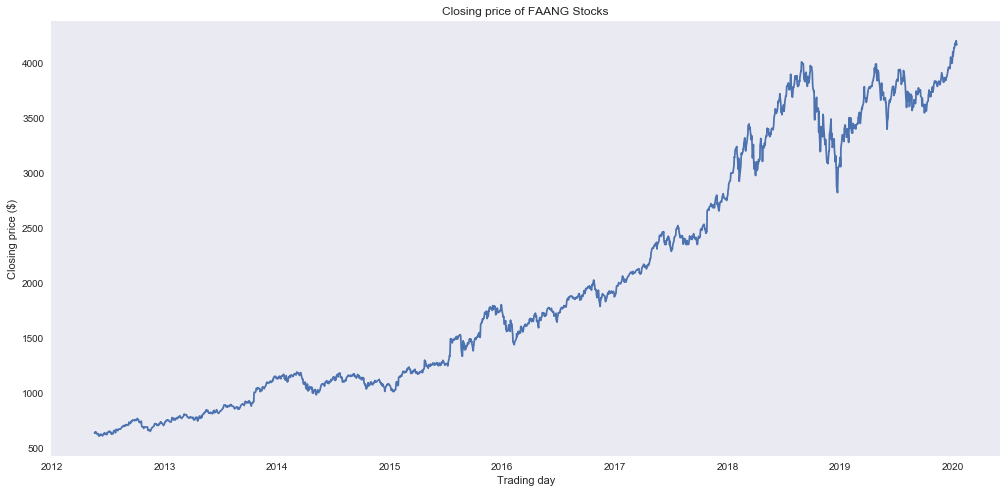

In [20]:
plt.figure(figsize=(17,8))
plt.plot(data.Close)
plt.title('Closing price of FAANG Stocks')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

In [26]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size={}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale*deviation)
        upper_bound = rolling_mean + (mae + scale*deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

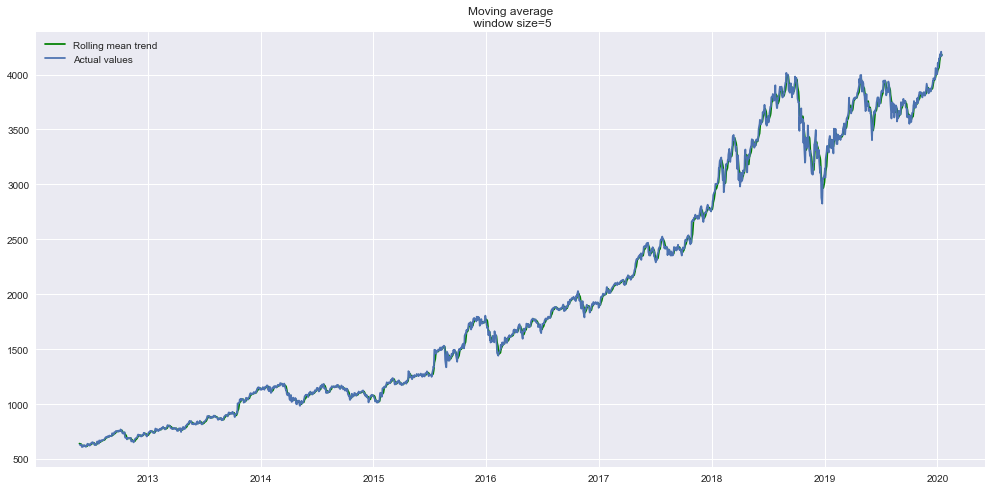

In [22]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

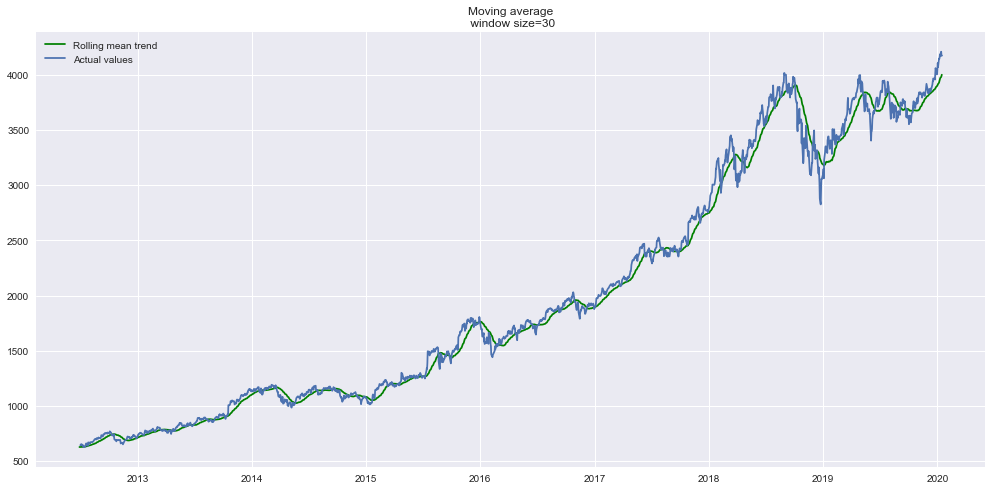

In [23]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Close, 30)

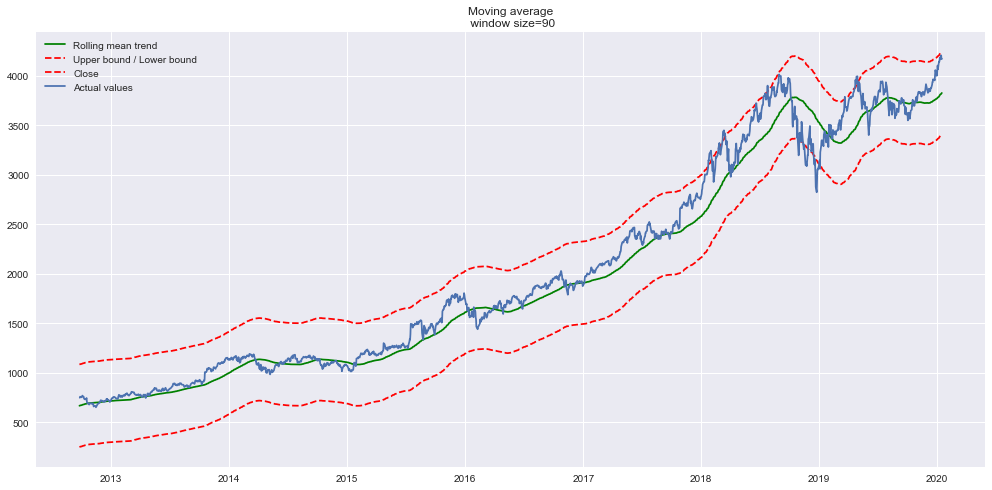

In [27]:
#Smooth by the previous quarter (90 days)
plot_moving_average(data.Close, 90, plot_intervals=True)

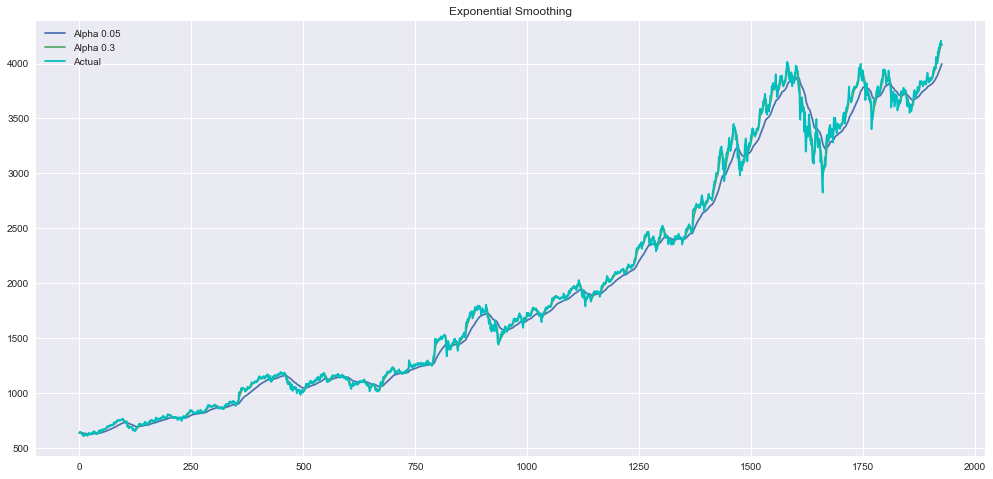

In [30]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
    
plot_exponential_smoothing(data.Close, [0.05, 0.3])

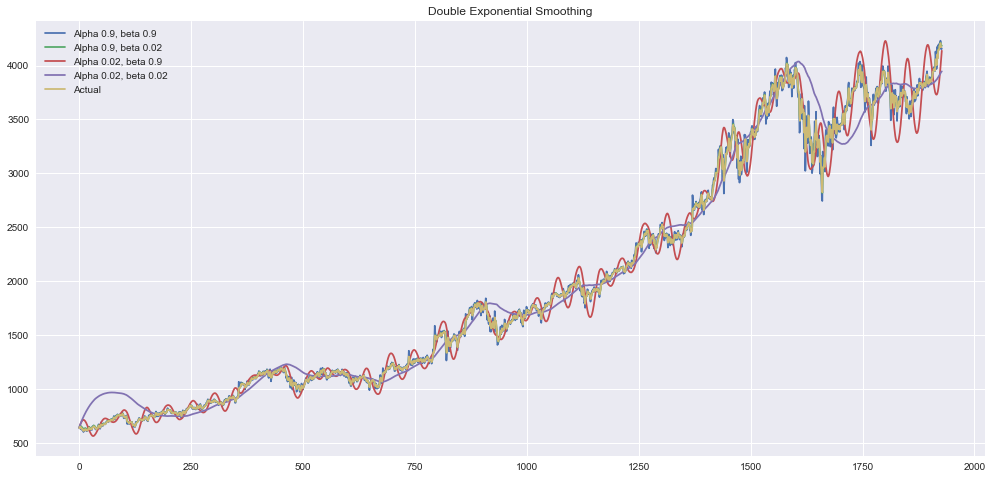

In [31]:
# Double exponential smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n==1:
            level, trend = series[0], series[1]-series[0]
        if n>=len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value +(1 - alpha) *(level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Modelling

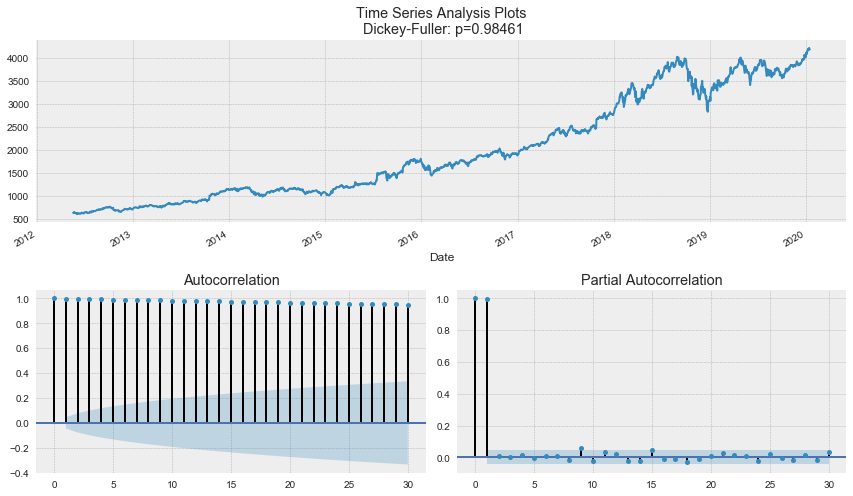

In [37]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)    

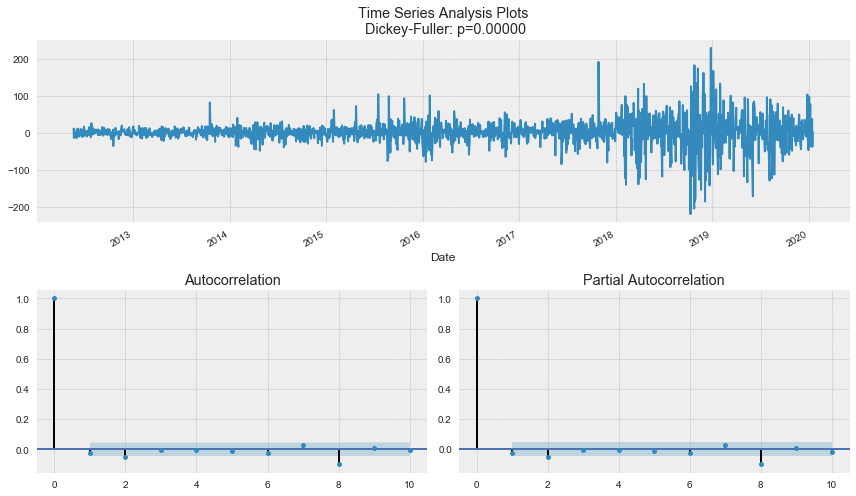

In [40]:
data_diff = data.Close - data.Close.shift(1)
tsplot(data_diff[1:], lags=10)